<a href="https://colab.research.google.com/github/Sea370/DL_school/blob/master/Autoencoders_project_S_Ananyev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (3 балла)

## Prepare the data


In [ ]:
#Скачивание dataset'а:
import numpy as np
import os
from imageio import imread
from PIL import Image

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

#np.array(Image.fromarray(img).resize([dimx,dimy]))

def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)
    
    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs
    
data, attrs = fetch_dataset()
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
print(IMAGE_H, IMAGE_W)


45 45


In [ ]:
len(data)

13143

In [ ]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
from torchvision import transforms

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
#from get_dataset import fetch_dataset
#data, attrs = fetch_dataset()

In [ ]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
# у нас цветные изображения
N_CHANNELS = 3

TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE

In [ ]:
DEVICE = torch.device("cuda")

In [ ]:
print(torch.cuda.is_available())

True



Разбейте выборку картинок на train и val и приведите значения элементов в интервал [0, 1] типа float

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,-0.632401,0.464839,-0.973528,1.56519,-1.2967,-1.54272,-0.684671,-0.86499,0.766886,-0.218952,-1.65567,-0.787044,-0.599665,0.458519,0.18976,0.851555,-0.38572,-0.497719,-0.161149,-0.257514,-0.0888388,0.455469,-0.839211,-0.0229481,-0.922568,-0.114539,1.46122,1.75848,0.0688935,1.26786,-1.12024,0.917617,-1.30796,-1.50041,1.02922,0.832363,-0.498657,0.251365,-0.705281,-0.515715,0.374239,-0.168675,-0.614143,3.0977,1.52386,0.779278,-0.0714539,-1.24648,-0.769283,-0.725597,-1.82061,-2.07298,-0.960759,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,-0.736883,0.294554,-1.27765,0.954771,-0.990992,-1.16736,-0.835146,0.798544,-0.971679,0.342826,-1.32256,0.962937,-1.19936,-0.157307,0.443224,-0.00288156,-0.0211584,-0.226563,-0.0810386,-0.827202,-0.106624,1.22759,-0.812223,-1.24126,0.0962725,-0.404544,0.325919,0.474452,1.13536,0.0587247,0.611176,-1.17251,0.428512,-0.874235,-1.19156,0.192359,-0.204166,0.342347,0.239512,-1.47469,0.236057,-0.565208,-0.712542,2.99708,-0.273306,-0.187722,-0.604608,-1.3217,-0.938559,0.494294,-0.659043,-1.14375,-0.775722,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,-1.20073,-0.33246,-0.537006,1.29836,-1.49847,-1.28582,1.14174,0.172817,0.106412,-0.788843,0.349295,-1.64372,0.454287,1.18946,-0.688414,-0.590574,-0.266673,0.467224,0.567348,-1.7191,0.124667,1.60274,-0.659399,-1.75376,1.20447,0.0221884,-1.13544,1.70286,-0.422144,0.587859,0.414363,0.344447,-1.26045,-0.577746,0.405567,-1.91655,0.92126,0.247437,-0.428451,-0.772273,0.370673,-0.509596,-0.768482,1.7069,0.126524,-0.497001,-0.393042,-0.178307,-1.18023,-0.596914,-1.80538,-0.951643,-0.838087,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,-0.0705188,-0.339239,-2.00415,0.665695,-0.77594,-1.47163,-1.17908,0.563327,-0.664429,-1.40793,0.435594,-0.589988,-1.6035,1.17074,0.760103,0.211498,-0.51618,-1.33115,0.20284,0.149645,-0.0464296,0.640885,-0.107616,-0.831271,-0.827005,-0.588725,0.429255,1.58766,0.499086,-0.0568692,-0.866643,-0.959689,0.35073,-1.33535,-0.42789,0.826817,-0.256779,0.149751,-1.20153,-1.08392,0.255363,-0.650423,-0.506293,1.10159,0.640783,1.57503,-0.484397,-1.55968,-1.43712,0.379363,-0.648233,-2.25735,-1.07561,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,-0.568057,0.840375,-1.98127,1.66671,-0.910723,-1.99351,-0.871335,0.507786,-0.488947,-0.88649,-0.990132,-0.750813,-0.378479,0.583086,-1.4796,0.250185,-0.381123,-0.611991,-0.143091,-1.07276,0.432094,1.08919,-0.470929,-1.17712,-0.111313,-0.154603,-1.03151,2.39246,-0.191576,1.2279,-1.3818,-1.52885,0.907964,-1.32429,-0

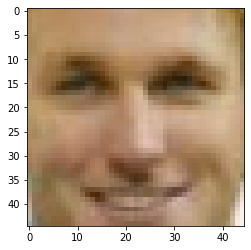

In [ ]:
data_new = np.array( data/ 255, dtype='float32')

X_train, y_train = data_new[:TRAIN_SIZE], attrs[:TRAIN_SIZE]
X_val, y_val = data_new[TRAIN_SIZE: data.shape[0]], attrs[TRAIN_SIZE: data_new.shape[0]]

plt.imshow(data_new[3])

pd.DataFrame(data=attrs)

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

In [ ]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3))) # cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

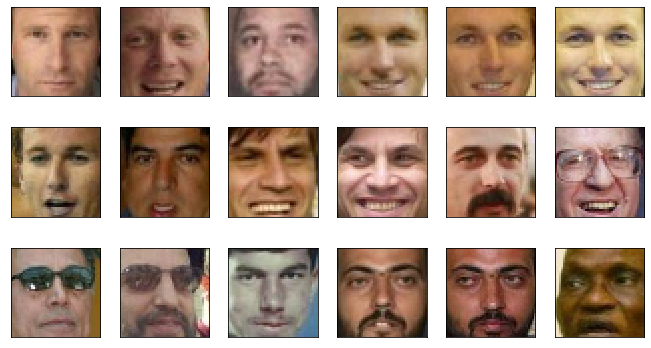

In [ ]:
plot_gallery(X_train, IMAGE_H, IMAGE_W)

Осталось привести картинки к тензорам из PyTorch, чтобы можно было потом скармливать их автоэнкодеру: 

## Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

In [ ]:
inp_size= 45 * 45 * 3
hid_size=250
dimZ = 100

print(inp_size)

6075


In [ ]:
from torch.utils.data import Dataset

class MyDataset(Dataset):

  def __init__(self, data_set):
    super().__init__()
    self.data_set = data_set

  def __len__(self):
    return len(self.data_set)

  def __getitem__(self, id):

    sample = self.data_set[id]

    transform = transforms.Compose([
            transforms.ToTensor()
        ])
        
    sample = transform(sample)

    sample = torch.flatten(sample)

    sample = sample.cuda()

    return sample

In [ ]:
Train_set = MyDataset(X_train)

Val_set = MyDataset(X_val)

In [ ]:
np.random.seed(42)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
#LINEAR MODEL
class AE_simple(nn.Module):

    def __init__(self):
        
        super().__init__()

        #encoder
        self.encoder = nn.Sequential(
          nn.Linear(inp_size, hid_size),
          nn.ReLU(),
          nn.BatchNorm1d(hid_size),
          nn.Linear(hid_size, dimZ))

        #decoder
        self.decoder = nn.Sequential(
          nn.Linear(dimZ, hid_size),
          nn.ReLU(),
          nn.BatchNorm1d(hid_size),
          nn.Linear(hid_size, inp_size))
        
    def forward(self,x):
        
        #<реализуйте forward проход автоэнкодера
        #в качестве возвращаемых переменных -- латентное представление картинки (latent_code) 
        #и полученная реконструкция изображения (reconstruction)>

        x = self.encoder(x)

        latent_code = x

        x = self.decoder(x)

        reconstruction = torch.sigmoid(x)

        return latent_code, reconstruction
    

In [ ]:
criterion = nn.MSELoss()

model = AE_simple().cuda() 

print(model)

AE_simple(
  (encoder): Sequential(
    (0): Linear(in_features=6075, out_features=250, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=250, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=250, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=250, out_features=6075, bias=True)
  )
)


Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Например, после каждой эпохи (прогона train выборки через автоэнкодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

Подсказка: если x_val -- картинка, а reconstruction -- ее реконструкция автоэнкодером, то красиво вывести эту каритинку и ее реконструкцию можно с помощью функции plot_gallery вот так:

*plot_gallery([x_val, reconstruction], image_h, image_w, n_row=1, n_col=2)*

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
def NewShape_1(x):
  x = torch.reshape(x, (1, 3, 45, 45))
  x = torch.transpose(x, 1, 3)
  x = torch.transpose(x, 1, 2)
  return x

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    
    running_loss = 0.0
    processed_size = 0

    for data_item in train_loader:

        inputs = Variable(data_item).cuda()
        
        optimizer.zero_grad()

        _ , outputs = model(inputs)

        loss = criterion(outputs, inputs)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)

    #выведем тестовые картинки
    inp_pic = NewShape_1(inputs[0])
    out_pic = NewShape_1(outputs[0])

    inp_pic = inp_pic.cpu()
    inp_pic = inp_pic.detach().numpy()

    out_pic = out_pic.cpu()
    out_pic = out_pic.detach().numpy()

    plot_gallery([inp_pic, out_pic], IMAGE_H, IMAGE_W, n_row=1, n_col=2)

    train_loss = running_loss/processed_size

    return train_loss

In [ ]:
def eval_epoch(model, val_loader, criterion):
    
    model.eval()
    running_loss = 0.0
    processed_size = 0

    for data_item in val_loader:

        inputs = Variable(data_item).cuda()

        with torch.set_grad_enabled(False):
            _, outputs = model(inputs)
            loss = criterion(outputs, inputs)

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)

    val_loss = running_loss/processed_size

    return val_loss

In [ ]:
def train(train_set, val_set, model, epochs, batch_size):
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

    history = []

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
      
        train_loss = fit_epoch(model, train_loader, criterion, optimizer)

        val_loss = eval_epoch(model, val_loader, criterion)

        print('epoch [{}/{}], train_loss:{:.4f}, val_loss:{:.4f}'
          .format(epoch + 1, epochs, train_loss, val_loss))
        
        history.append((train_loss, val_loss))
    
    return history

epoch [1/30], train_loss:0.0170, val_loss:0.0126
epoch [2/30], train_loss:0.0118, val_loss:0.0094
epoch [3/30], train_loss:0.0091, val_loss:0.0087
epoch [4/30], train_loss:0.0084, val_loss:0.0081
epoch [5/30], train_loss:0.0079, val_loss:0.0077
epoch [6/30], train_loss:0.0074, val_loss:0.0072
epoch [7/30], train_loss:0.0071, val_loss:0.0069
epoch [8/30], train_loss:0.0067, val_loss:0.0066
epoch [9/30], train_loss:0.0064, val_loss:0.0063
epoch [10/30], train_loss:0.0062, val_loss:0.0062
epoch [11/30], train_loss:0.0060, val_loss:0.0060
epoch [12/30], train_loss:0.0058, val_loss:0.0059
epoch [13/30], train_loss:0.0057, val_loss:0.0057
epoch [14/30], train_loss:0.0056, val_loss:0.0056
epoch [15/30], train_loss:0.0055, val_loss:0.0056
epoch [16/30], train_loss:0.0054, val_loss:0.0055
epoch [17/30], train_loss:0.0053, val_loss:0.0055
epoch [18/30], train_loss:0.0052, val_loss:0.0054
epoch [19/30], train_loss:0.0051, val_loss:0.0052
epoch [20/30], train_loss:0.0050, val_loss:0.0052


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


epoch [21/30], train_loss:0.0049, val_loss:0.0051
epoch [22/30], train_loss:0.0049, val_loss:0.0050
epoch [23/30], train_loss:0.0048, val_loss:0.0050
epoch [24/30], train_loss:0.0048, val_loss:0.0049
epoch [25/30], train_loss:0.0047, val_loss:0.0048
epoch [26/30], train_loss:0.0046, val_loss:0.0048
epoch [27/30], train_loss:0.0046, val_loss:0.0048
epoch [28/30], train_loss:0.0045, val_loss:0.0047
epoch [29/30], train_loss:0.0045, val_loss:0.0047
epoch [30/30], train_loss:0.0044, val_loss:0.0046


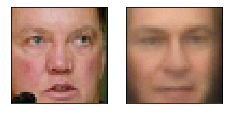

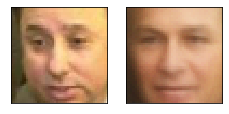

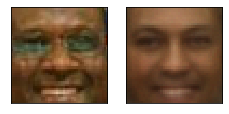

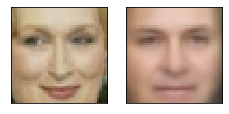

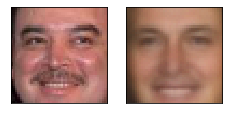

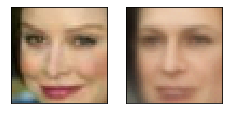

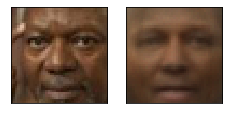

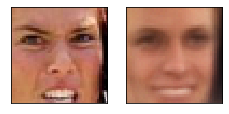

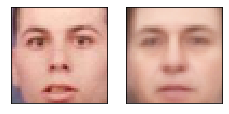

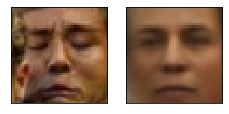

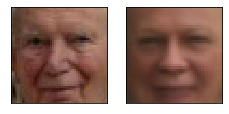

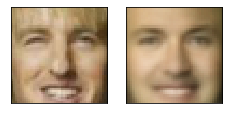

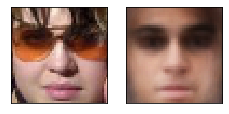

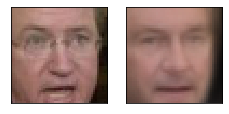

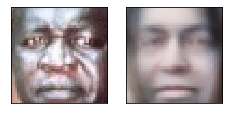

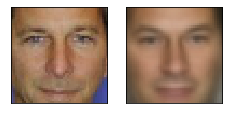

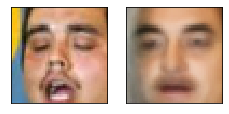

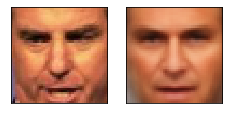

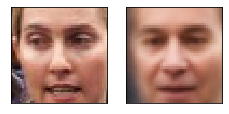

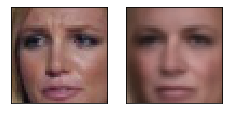

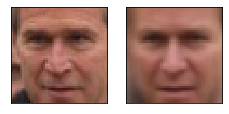

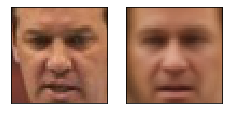

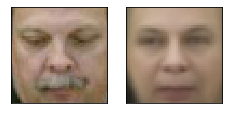

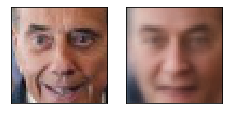

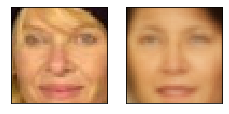

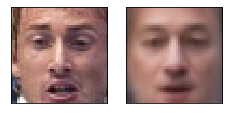

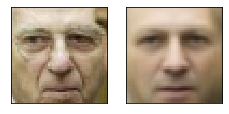

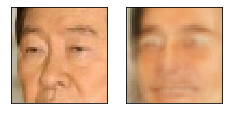

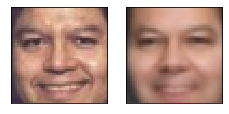

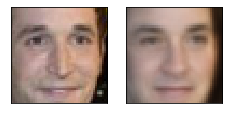

In [ ]:
history = train(Train_set, Val_set, model=model, epochs=30, batch_size=100)

In [ ]:
loss, val_loss = zip(*history)

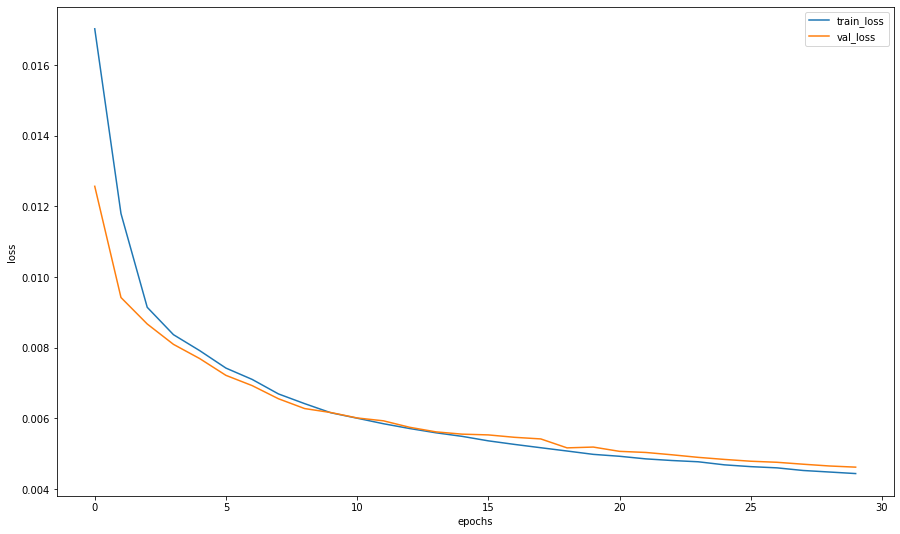

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Давайте посмотрим, как наш тренированный автоэнкодер кодирует и восстанавливает картинки:

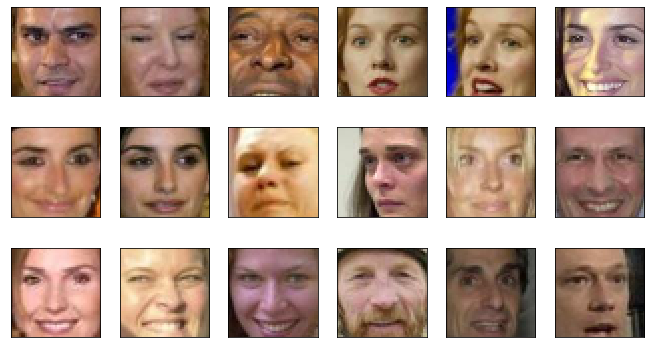

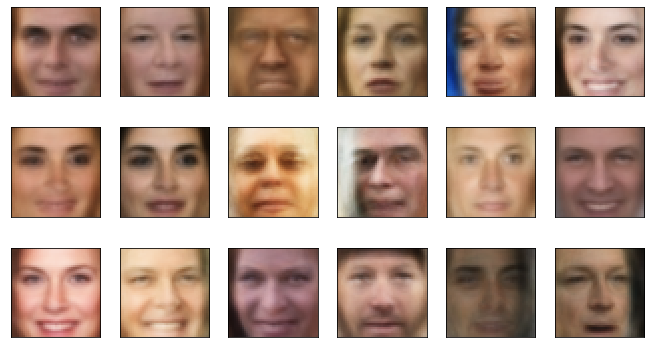

In [ ]:
#< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

def NewShape(x):
  x = torch.reshape(x, (20, 3, 45, 45))
  x = torch.transpose(x, 1, 3)
  x = torch.transpose(x, 1, 2)
  return x

X_val_set = MyDataset(X_val[:20])

X_val_loader = torch.utils.data.DataLoader(X_val_set, batch_size=20, shuffle=False)

model.eval()

for item in X_val_loader:

    inputs = Variable(item).cuda()

    with torch.set_grad_enabled(False):
        latent_code, outputs = model(inputs)

    inputs = NewShape(inputs)

    inputs = inputs.data.cpu()

    plot_gallery(inputs, IMAGE_H, IMAGE_W)

    out_pics = NewShape(outputs)

    out_pics = out_pics.data.cpu().numpy()

    plot_gallery(out_pics, IMAGE_H, IMAGE_W)
        

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что придется рандом подогнать.

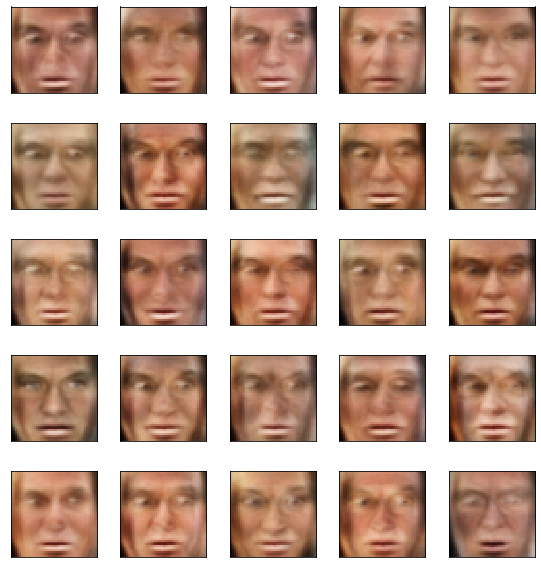

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space

z = torch.tensor(np.random.randn(25, 100)) 

z = z.to(device='cuda', dtype=torch.float32)

output = torch.sigmoid(model.decoder(z))

def NewShape1(x):
  x = torch.reshape(x, (25, 3, 45, 45))
  x = torch.transpose(x, 1, 3)
  x = torch.transpose(x, 1, 2)
  return x

output = NewShape1(output)

plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=5, n_col=5)

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
#<а вот тут все это надо запрогать, да>

df = pd.DataFrame(data=attrs)

df_smiling = df[df['Smiling'] >= 0.7]

df_smiling[0:15]


,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,-0.736883,0.294554,-1.27765,0.954771,-0.990992,-1.16736,-0.835146,0.798544,-0.971679,0.342826,-1.32256,0.962937,-1.19936,-0.157307,0.443224,-0.00288156,-0.0211584,-0.226563,-0.0810386,-0.827202,-0.106624,1.22759,-0.812223,-1.24126,0.0962725,-0.404544,0.325919,0.474452,1.13536,0.0587247,0.611176,-1.17251,0.428512,-0.874235,-1.19156,0.192359,-0.204166,0.342347,0.239512,-1.47469,0.236057,-0.565208,-0.712542,2.99708,-0.273306,-0.187722,-0.604608,-1.3217,-0.938559,0.494294,-0.659043,-1.14375,-0.775722,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
5,0.850491,-1.48208,1.90852,-1.87365,-3.22993,-0.864006,0.31382,-0.35268,-1.55929,-1.91459,-0.183774,-0.611104,-1.12559,1.88155,-1.42656,-2.02517,-1.08598,1.32771,-1.49902,-1.0821,-1.51491,-0.619491,-0.724844,0.239398,-0.00587801,0.861121,0.281811,-0.896384,0.50386,-0.665195,-0.0108389,1.01641,-0.507268,-0.712192,-0.395029,-0.543325,1.09159,1.88456,0.355624,0.241287,-0.829593,-0.724306,1.19546,-1.8133,-0.788424,0.739353,-0.856222,-0.104318,-0.911016,-0.821423,-0.227976,-0.214095,-0.914161,0.484954,2.05128,1.16484,-0.0113163,-1.47652,-1.78473,1.32262,-0.465064,-3.41187,-0.935043,1.77547,-1.0635,1.35435,-0.960133,-5.35464,1.15002,-0.142195,-0.672725,0.886694,-0.154051
8,0.286489,-1.90351,0.697239,-1.85985,-1.44025,-1.55243,0.102555,-0.191471,-0.726333,-0.226157,-0.960942,0.883486,-1.54019,2.03712,-1.79367,-1.06284,-0.815287,1.04339,-1.03926,-0.336566,-0.955972,-0.3267,-0.602744,-0.0301018,0.0609864,-0.18539,-1.04398,0.110099,-1.125,0.888272,0.11737,-0.9451,-0.427191,-0.219541,-0.211102,0.169996,0.980864,0.141318,0.689054,0.76991,-0.903777,-1.11681,-0.215057,-0.0207795,-1.03589,0.153006,-0.219807,0.181432,-0.286476,-1.05326,-0.149979,-0.753525,-0.44484,3.29466,-0.313387,0.155056,-0.671935,-0.376232,-1.48105,0.285955,-0.662831,-2.5849,-0.398156,-1.41784,-0.483956,0.717483,-0.288405,-2.29545,0.937971,1.23307,-0.632812,0.00999485,-0.144265
9,0.663497,-1.03694,0.46161,-2.49853,-2.81593,-1.63779,-0.20148,-0.134941,-1.32816,-0.712721,-1.04643,0.751971,-1.07845,0.508052,-0.955831,-1.39705,-0.393789,1.27319,-0.921499,-1.19207,-0.650999,-0.0646937,-1.16104,0.474989,0.680129,-0.134076,-0.957666,0.815776,-0.771003,-0.712388,-0.310099,-0.598794,-0.413883,-0.998702,-0.145115,-0.972335,0.791311,1.37849,1.32976,-0.164918,-0.0251796,-0.119012,-0.277203,-0.776074,-0.735357,-0.533107,-0.027968,-0.00688656,-0.858842,-1.03422,0.0417565,-0.431964,-0.884496,2.59033,0.89871,0.472471,-0.892174,-0.419689,-1.5762,1.68762,-0.78384,-0.441403,-1.19935,1.43291,0.771419,1.59549,-0.697505,-2.51197,0.98124,0.424768,-0.518236,-0.306921,0.348492
11,0.891376,-0.438415,-0.0914528,-1.7389,-1.02499,-1.46406,-0.720319,-0.660456,0.422967,-0.994338,-0.861802,-1.47849,0.0448106,-1.83904,1.364,-1.05956,-0.708427,1.04279,-0.985953,-0.0153609,-0.870919,0.209452,-0.612433,0.00251882,-0.0262948,1.20671,-0.469633,-0.115299,1.50081,-1.17389,-0.150321,1.72087,-0.756571,-1.15229,-0.130448,0.306728,0.901029,0.281118,1.52427,-0.320513,-0.673076,

In [ ]:
df_smiling[0:15].index

Int64Index([1, 5, 8, 9, 11, 18, 26, 34, 60, 83, 88, 96, 98, 101, 106], dtype='int64')

In [ ]:
df_sad = df[df['Smiling'] <= -0.7]

In [ ]:
df_sad[0:15].index

Int64Index([0, 6, 7, 10, 14, 16, 17, 22, 24, 25, 29, 48, 49, 50, 53], dtype='int64')

In [ ]:
latent_code = torch.zeros(15, 100).cuda()

for i in range(15):

    index = df_smiling[0:15].index[i]

    with torch.set_grad_enabled(False):

        latent_code[i] = model.encoder(Train_set[index].view(1, 6075))

latent_smile = latent_code.mean(dim=0)


latent_code = torch.zeros(15, 100).cuda()

for i in range(15):

    index = df_sad[0:15].index[i]

    with torch.set_grad_enabled(False):

        latent_code[i] = model.encoder(Train_set[index].view(1, 6075))

latent_sad = latent_code.mean(dim=0)

vector_smile = latent_smile - latent_sad

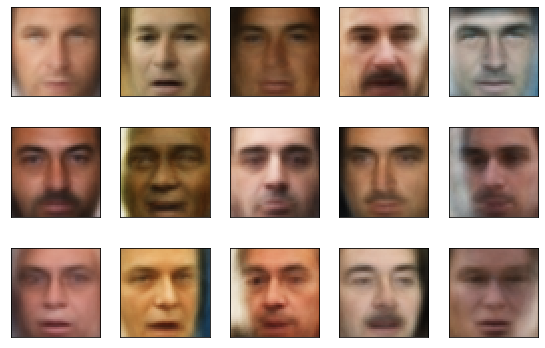

In [ ]:
#выводим "грустных"
latent_code = latent_code.to(device='cuda', dtype=torch.float32)

output = torch.sigmoid(model.decoder(latent_code))

def NewShape2(x):
  x = torch.reshape(x, (15, 3, 45, 45))
  x = torch.transpose(x, 1, 3)
  x = torch.transpose(x, 1, 2)
  return x

output = NewShape2(output)

plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=3, n_col=5)

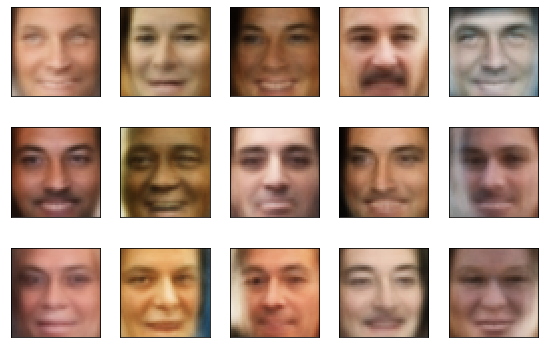

In [ ]:
#их же с улыбками
vector_smile = vector_smile.to(device='cuda', dtype=torch.float32)

output = torch.sigmoid(model.decoder(latent_code+vector_smile))

output = NewShape2(output)

plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=3, n_col=5)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии)

# Conditional Autoencoder (3 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет

Как вы уже догадались, здесь мы будем использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/)

Если он вам очень не нравится, можете загуглить любой другой, в котором будет четкое разделение картинок по классам.

In [ ]:
#<тут надо обработать датасет, построить и обучить Conditional AE (код обычного AE прекрасно берется за основу)>
from tqdm import tqdm, tqdm_notebook
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
from torchvision import transforms

%matplotlib inline

import matplotlib.pyplot as plt

from torchvision import datasets, transforms

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
batch_size = 100

In [ ]:
mnist_train_dataset = datasets.MNIST('./data', transform=transforms.ToTensor(), download=True)
mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True)

mnist_test_dataset = datasets.MNIST('./data', transform=transforms.ToTensor(), download=True, train=False)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=batch_size, shuffle=False)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [ ]:
mnist_train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

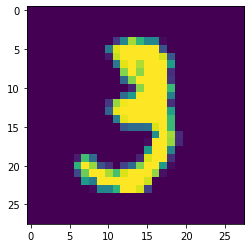

In [ ]:
X, y = mnist_train_dataset[10]

def NewShape_mnist(x):
  x = torch.reshape(x, (28, 28))
  return x

X = NewShape_mnist(X)

plt.imshow(X)


In [ ]:
def one_hot(x, max_x):
    return torch.eye(max_x+1)[x]

In [ ]:
one_hot(1, 9)

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
def plot_gallery_new(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w))) # cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

In [ ]:
#CONDITIONAL AE

Max_Label = 9
Hidden_Size = 5

class Autoencoder_conditional(nn.Module):
    def __init__(self, input_size=784, max_label=Max_Label, hidden_size=Hidden_Size):
        
        super().__init__()

        self.max_label = max_label

        input_size_with_label = input_size + self.max_label + 1
        
        hidden_size_new = hidden_size + self.max_label + 1

        #encoder
        self.encoder = nn.Sequential(
          nn.Linear(input_size_with_label, 250),
          nn.ReLU(),
          nn.BatchNorm1d(250),
          nn.Linear(250, hidden_size))

        #decoder
        self.decoder = nn.Sequential(
          nn.Linear(hidden_size_new, 250),
          nn.ReLU(),
          nn.BatchNorm1d(250),
          nn.Linear(250, input_size))
        
    def forward(self, x, targets):
      
        #<реализуйте forward проход автоэнкодера
        #в качестве возвращаемых переменных -- латентное представление картинки (latent_code) 
        #и полученная реконструкция изображения (reconstruction)>

        targets = one_hot(targets, self.max_label).float()

        targets = targets.cuda()

        x = torch.cat((x, targets), 1)

        x = self.encoder(x)

        latent_code = x

        x = torch.cat((x, targets), 1)

        x = self.decoder(x)

        reconstruction = x

        return latent_code, reconstruction

In [ ]:
criterion = nn.MSELoss()

model = Autoencoder_conditional().cuda() 

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(model)

Autoencoder_conditional(
  (encoder): Sequential(
    (0): Linear(in_features=794, out_features=250, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=250, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=250, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=250, out_features=784, bias=True)
  )
)


In [ ]:
num_epochs = 20

for epoch in range(num_epochs):

    for batch, labels in mnist_train_dataloader:
        
        batch_new = batch.view(batch_size, 28*28)

        inputs = batch_new.cuda()

        labels = labels.cuda()
        
        optimizer.zero_grad()

        latent_code , outputs = model(inputs, labels)

        loss = criterion(outputs, inputs)
        

        loss.backward()
        optimizer.step()


    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))

epoch [1/20], loss:0.0326
epoch [2/20], loss:0.0289
epoch [3/20], loss:0.0268
epoch [4/20], loss:0.0287
epoch [5/20], loss:0.0269
epoch [6/20], loss:0.0291
epoch [7/20], loss:0.0273
epoch [8/20], loss:0.0263
epoch [9/20], loss:0.0279
epoch [10/20], loss:0.0295
epoch [11/20], loss:0.0270
epoch [12/20], loss:0.0276
epoch [13/20], loss:0.0245
epoch [14/20], loss:0.0283
epoch [15/20], loss:0.0261
epoch [16/20], loss:0.0256
epoch [17/20], loss:0.0266
epoch [18/20], loss:0.0278
epoch [19/20], loss:0.0248
epoch [20/20], loss:0.0238


In [ ]:
#приводим векторы к правильной форме:

inp_pics = inputs.view(batch_size, 28, 28).cpu()
inp_pics = inp_pics.detach().numpy()

out_pics = outputs.view(batch_size, 28, 28).cpu()
out_pics = out_pics.detach().numpy()

out_pics.shape

(100, 28, 28)

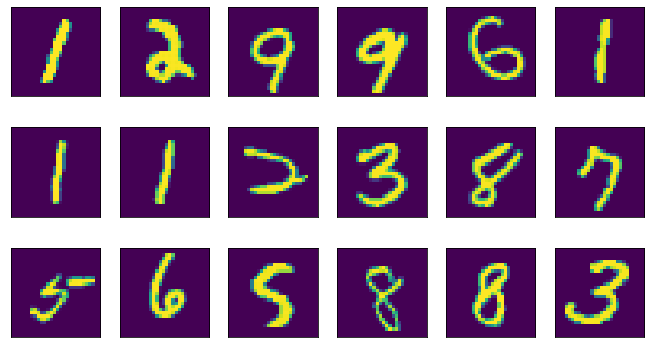

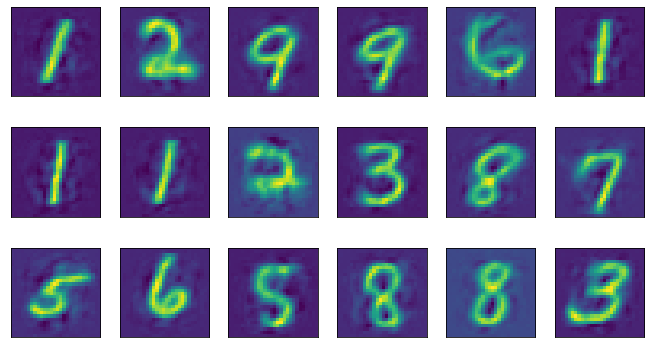

In [ ]:
#исходные
plot_gallery_new(inp_pics, 28, 28)

#реконструкция
plot_gallery_new(out_pics, 28, 28)

## Sampling


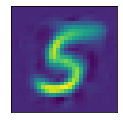

In [ ]:
#<тут нужно научиться сэмплировать из декодера цифры определенного класса>

model.eval()

z = torch.randn(1, Hidden_Size).cuda()

#Здесь выбираем цифру к-рую будем генерить
N = 5

target = one_hot(N, Max_Label).view(1, Max_Label+1)

target = target.cuda()

x = torch.cat((z, target), dim=1)

output = model.decoder(x.view(1, Hidden_Size + Max_Label +1))

out_pic = output.view(1, 28, 28).cpu()
out_pic = out_pic.detach().numpy()

plot_gallery_new(out_pic, 28, 28, n_row=1, n_col=1)


Splendid! Вы великолепны!

Теперь давайте сделаем следующее: посмотрим на то, как выглядит латентное пространство векторов, соответствующих нашим картинкам. 
Для этого вам нужно:
1.  прогнать картинки из датасета через encoder, получить латентные векторы
2. Прогнать векторы через TSNE, получить их двумерную проекцию
3. Изобразить полученные после TSNE двумерные векторы на плоскости с помощью plt.scatter, покрасив точки в цвета в зависимости от класса картинки, которой она соответствует. (как красить точки, см. в документации к plt.scatter). 
4. Подумать, что вы видите и записать свои мысли

In [ ]:
#<тут код получения латентных векторов, прогона через TSNE и рисования scatter plot>
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

model.eval()

Sample_Num = 500

latent_code = torch.zeros(Sample_Num, Hidden_Size).cuda()

lb = []

for i in range(Sample_Num):

    pic, label = mnist_test_dataset[i]

    pic = pic.view(1, 28*28).cuda()

    target = one_hot(label, Max_Label).float()

    target = target.view(1, 10).cuda()

    x = torch.cat((pic, target), 1)

    with torch.set_grad_enabled(False):

        latent_code[i] = model.encoder(x)

    lb.append(label)

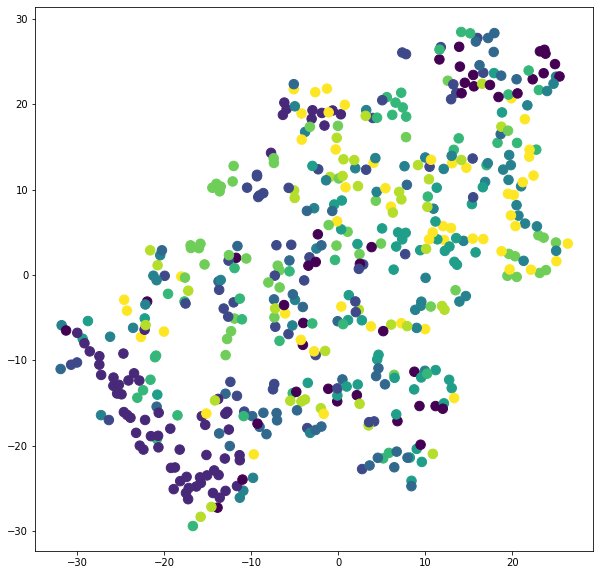

In [ ]:
X = latent_code.cpu().detach().numpy()

from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate=100, perplexity=20, n_iter=500).fit_transform(X)

np.random.seed(0)

x = X_embedded[:,0]
y = X_embedded[:,1]

colors = lb
area = 90

plt.figure(figsize=(10, 10))

sc = plt.scatter(x, y, s=area, c=colors, alpha=1)

#Возможность отобразить метки на точках
#for i,label in enumerate(lb):
    #xp = x[i]
    #yp = y[i]
    #plt.text(xp+0.1, yp+0.3, label, fontsize=10)

plt.show()

Пространство Conditional AE выглядит достаточно "разреженным", имеются "пустоты".

# BONUS 1. (2 балла) 
### Variational Autoencoder

Если вы (надеюсь) осознали, в каком месте у conditional AE выше могли бы быть проблемы, то -- тадам!!

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [ ]:
#Используем датасет из первого задания

Train_set = MyDataset(X_train)

In [ ]:
batch_size = 100

dataloader = torch.utils.data.DataLoader(Train_set, batch_size=batch_size, shuffle=True)

class VAE(nn.Module):
    def __init__(self):
        #<определите архитектуры encoder и decoder
        #помните, у encoder должны быть два "хвоста", 
        #т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
          nn.Linear(inp_size, hid_size),
          nn.ReLU(),
          nn.BatchNorm1d(hid_size))
        
        self.enco_tail_1 = nn.Linear(hid_size, dimZ)
        self.enco_tail_2 = nn.Linear(hid_size, dimZ)

        self.decoder = nn.Sequential(
          nn.Linear(dimZ, hid_size),
          nn.ReLU(),
          nn.BatchNorm1d(hid_size),
          nn.Linear(hid_size, inp_size))

    def encode(self, x):
        #<реализуйте forward проход энкодера
        #в качестве возвращаемых переменных -- mu и logsigma>

        h = self.encoder(x)
        
        mu = self.enco_tail_1(h)
        
        logsigma = self.enco_tail_2(h)
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """

        if self.training:
            std = logsigma.mul(0.5).exp_()
            eps = torch.cuda.FloatTensor(std.size()).normal_()
            eps = Variable(eps)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        #<реализуйте forward проход декодера
        #в качестве возвращаемой переменной -- reconstruction>
         
        reconstruction = self.decoder(z)
        
        return reconstruction

    def forward(self, x):
        #<используя encode и decode, реализуйте forward проход автоэнкодера
        #в качестве возвращаемых переменных -- mu, logsigma и reconstruction>

        mu, logsigma = self.encode(x)
        
        z = self.gaussian_sampler(mu, logsigma)

        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """

    KLD = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    
    return KLD

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """

    loss = nn.MSELoss(reduction='sum')

    return loss(reconstruction, x)


def loss_vae(x, mu, logsigma, reconstruction):

    return (KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)).mean()


И обучим модель:

In [ ]:
model_vae = VAE().cuda() 

optimizer = torch.optim.Adam(model_vae.parameters(), lr=0.01)

print(model_vae)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=6075, out_features=250, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (enco_tail_1): Linear(in_features=250, out_features=100, bias=True)
  (enco_tail_2): Linear(in_features=250, out_features=100, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=250, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=250, out_features=6075, bias=True)
  )
)


In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
    
    model_vae.train()

    for data_item in dataloader:
        
        inputs = Variable(data_item).cuda()
        
        optimizer.zero_grad()

        mu, logsigma, reconstruction = model_vae(inputs)
      
        loss = loss_vae(inputs, mu, logsigma, reconstruction) / 10000
        
        loss.backward()
        optimizer.step()

    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))

epoch [1/50], loss:1.3820
epoch [2/50], loss:1.2948
epoch [3/50], loss:1.0592
epoch [4/50], loss:0.9968
epoch [5/50], loss:0.8592
epoch [6/50], loss:0.8435
epoch [7/50], loss:0.8320
epoch [8/50], loss:0.8046
epoch [9/50], loss:0.7758
epoch [10/50], loss:0.8092
epoch [11/50], loss:0.7412
epoch [12/50], loss:0.7893
epoch [13/50], loss:0.8299
epoch [14/50], loss:0.7704
epoch [15/50], loss:0.7651
epoch [16/50], loss:0.8192
epoch [17/50], loss:0.8354
epoch [18/50], loss:0.7279
epoch [19/50], loss:0.7022
epoch [20/50], loss:0.7566
epoch [21/50], loss:0.7185
epoch [22/50], loss:0.7265
epoch [23/50], loss:0.6959
epoch [24/50], loss:0.7174
epoch [25/50], loss:0.7213
epoch [26/50], loss:0.7094
epoch [27/50], loss:0.6943
epoch [28/50], loss:0.7687
epoch [29/50], loss:0.7623
epoch [30/50], loss:0.7196
epoch [31/50], loss:0.7542
epoch [32/50], loss:0.7580
epoch [33/50], loss:0.7735
epoch [34/50], loss:0.7412
epoch [35/50], loss:0.7389
epoch [36/50], loss:0.7333
epoch [37/50], loss:0.7425
epoch [38/

In [ ]:
#приводим векторы к правильной форме:

def NewShape(x):
  x = torch.reshape(x, (100, 3, 45, 45))
  x = torch.transpose(x, 1, 3)
  x = torch.transpose(x, 1, 2)
  return x

inp_pics = NewShape(inputs)

out_pics = NewShape(reconstruction)

inp_pics.shape

torch.Size([100, 45, 45, 3])

In [ ]:
inp_pics = inp_pics.cpu()
inp_pics = inp_pics.detach().numpy()

out_pics = out_pics.cpu()
out_pics = out_pics.detach().numpy()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


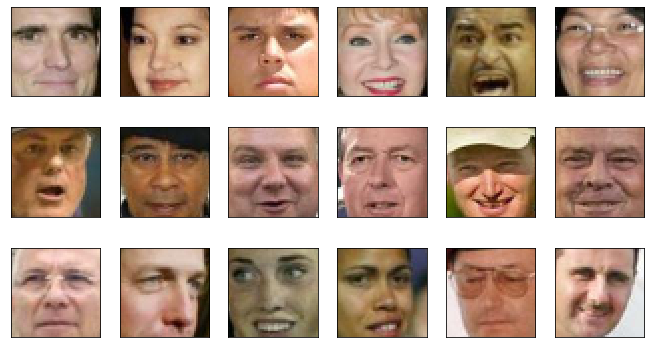

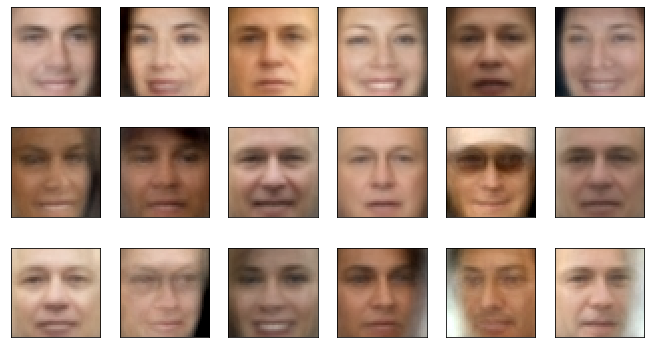

In [ ]:
#< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

#исходные
plot_gallery(inp_pics, IMAGE_H, IMAGE_W)

#реконструкция
plot_gallery(out_pics, IMAGE_H, IMAGE_W)



And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие лица получатся:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


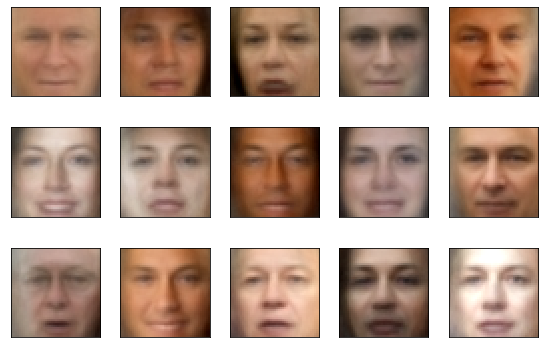

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
model_vae.eval()

z = np.array([np.random.normal(0, 1, 100) for i in range(15)])

z = torch.cuda.FloatTensor(z)

output = model_vae.decode(z)

def NewShape2(x):
  x = torch.reshape(x, (15, 3, 45, 45))
  x = torch.transpose(x, 1, 3)
  x = torch.transpose(x, 1, 2)
  return x

output = NewShape2(output)


plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=3, n_col=5)

## Congrats v2.0!

Как вы уже догадались, здесь тоже можно попробовать пририсовывать разные атрибуты людям. Можно, например, так же пририсовать улыбки и сравнить с тем, как это получалось у обычного автоэнкодера

In [ ]:
df = pd.DataFrame(data=attrs)

df_smiling = df[df['Smiling'] >= 0.3]

df_sad = df[df['Smiling'] <= -0.7]


In [ ]:
latent_code = torch.zeros(15, 100).cuda()

for i in range(15):

    index = df_smiling[0:15].index[i]

    with torch.set_grad_enabled(False):

        mu, logsigma = model_vae.encode(Train_set[index].view(1, 6075))

        latent_code[i] = model_vae.gaussian_sampler(mu, logsigma)

latent_smile = latent_code.mean(dim=0)


latent_code = torch.zeros(15, 100).cuda()

for i in range(15):

    index = df_sad[0:15].index[i]

    with torch.set_grad_enabled(False):

        mu, logsigma = model_vae.encode(Train_set[index].view(1, 6075))

        latent_code[i] = model_vae.gaussian_sampler(mu, logsigma)

latent_sad = latent_code.mean(dim=0)

vector_smile = latent_smile - latent_sad

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


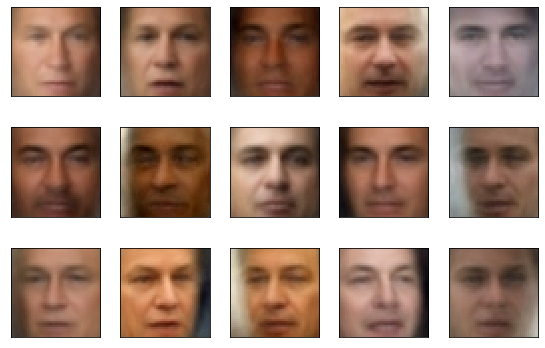

In [ ]:
#выводим картинки "грустных"
latent_code = latent_code.to(device='cuda', dtype=torch.float32)

output = model_vae.decode(latent_code)

def NewShape2(x):
  x = torch.reshape(x, (15, 3, 45, 45))
  x = torch.transpose(x, 1, 3)
  x = torch.transpose(x, 1, 2)
  return x

output = NewShape2(output)

plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=3, n_col=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


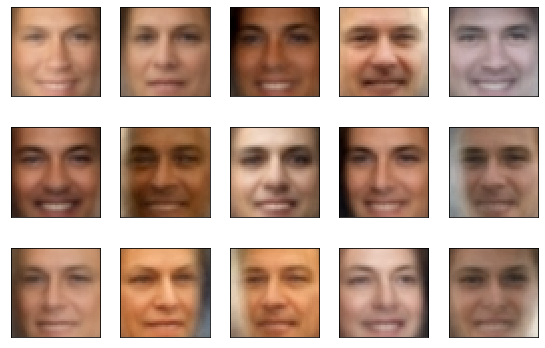

In [ ]:
#те же с улыбками
vector_smile = vector_smile.to(device='cuda', dtype=torch.float32)

output = model_vae.decode(latent_code+vector_smile)

output = NewShape2(output)

plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=3, n_col=5)

# BONUS 2. (2 балла)

А теперь пришло время сделать 
## Conditional Variational AE

In [ ]:
#<тут обучение Conditional Variational AE>

Max_Label = 9
Int_Dim = 10

class Autoencoder_CVAE(nn.Module):
    def __init__(self, input_size=784, hid_size=250, dimZ=Int_Dim, max_label=Max_Label):
        
        super().__init__()

        self.max_label = max_label

        input_size_with_label = input_size + self.max_label + 1
        
        dimZ_new = dimZ + self.max_label + 1

        #encoder
        self.encoder = nn.Sequential(
          nn.Linear(input_size_with_label, hid_size),
          nn.ReLU(),
          nn.BatchNorm1d(hid_size))
        
        self.enco_tail_1 = nn.Linear(hid_size, dimZ)
        self.enco_tail_2 = nn.Linear(hid_size, dimZ)

        #decoder
        self.decoder = nn.Sequential(
          nn.Linear(dimZ_new, hid_size),
          nn.ReLU(),
          nn.BatchNorm1d(hid_size),
          nn.Linear(hid_size, input_size))

    def encode(self, x):

        h = self.encoder(x)
        
        mu = self.enco_tail_1(h)
        
        logsigma = self.enco_tail_2(h)
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """

        std = logsigma.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        
        return eps.mul(std).add_(mu)

    def decode(self, z):
         
        reconstruction = self.decoder(z)
        
        return reconstruction

    def forward(self, x, targets):

        targets = one_hot(targets, self.max_label).float()

        targets = targets.cuda()

        x = torch.cat((x, targets), 1)

        mu, logsigma = self.encode(x)
        
        z = self.gaussian_sampler(mu, logsigma)

        z = torch.cat((z, targets), 1)

        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    
    return -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """

    loss = nn.MSELoss(reduction='sum')  
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):

    return (KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)).mean()

In [ ]:
model_cvae = Autoencoder_CVAE().cuda() 

optimizer = torch.optim.Adam(model_cvae.parameters(), lr=0.01)

print(model_cvae)

Autoencoder_CVAE(
  (encoder): Sequential(
    (0): Linear(in_features=794, out_features=250, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (enco_tail_1): Linear(in_features=250, out_features=10, bias=True)
  (enco_tail_2): Linear(in_features=250, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=250, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=250, out_features=784, bias=True)
  )
)


In [ ]:
num_epochs = 25

for epoch in range(num_epochs):
    
    model_cvae.train()

    for batch, labels in mnist_train_dataloader:

        batch_new = batch.view(100, 28*28)

        inputs = batch_new.cuda()

        labels = labels.cuda()

        optimizer.zero_grad()

        mu, logsigma, reconstruction = model_cvae(inputs, labels)
      
        loss = loss_vae(inputs, mu, logsigma, reconstruction) / 60000
        
        loss.backward()
        optimizer.step()

    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))

epoch [1/25], loss:0.0501
epoch [2/25], loss:0.0493
epoch [3/25], loss:0.0505
epoch [4/25], loss:0.0495
epoch [5/25], loss:0.0503
epoch [6/25], loss:0.0530
epoch [7/25], loss:0.0492
epoch [8/25], loss:0.0513
epoch [9/25], loss:0.0469
epoch [10/25], loss:0.0535
epoch [11/25], loss:0.0481
epoch [12/25], loss:0.0477
epoch [13/25], loss:0.0513
epoch [14/25], loss:0.0503
epoch [15/25], loss:0.0493
epoch [16/25], loss:0.0496
epoch [17/25], loss:0.0498
epoch [18/25], loss:0.0500
epoch [19/25], loss:0.0498
epoch [20/25], loss:0.0500
epoch [21/25], loss:0.0501
epoch [22/25], loss:0.0461
epoch [23/25], loss:0.0499
epoch [24/25], loss:0.0470
epoch [25/25], loss:0.0521


In [ ]:
inp_pics = inputs.view(100, 28, 28).cpu()
inp_pics = inp_pics.detach().numpy()

out_pics = reconstruction.view(100, 28, 28).cpu()
out_pics = out_pics.detach().numpy()

out_pics.shape

(100, 28, 28)

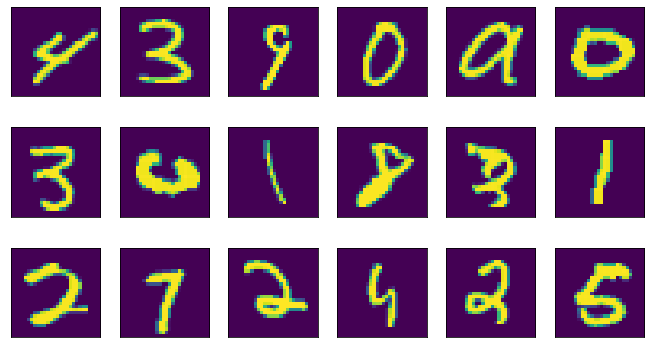

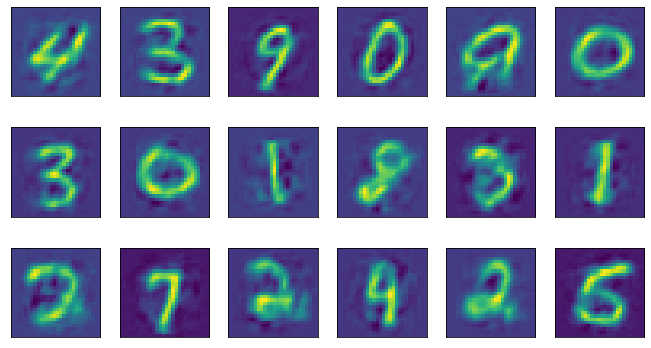

In [ ]:
#исходные
plot_gallery_new(inp_pics, 28, 28)

#реконструкция
plot_gallery_new(out_pics, 28, 28)

... и так же посмотреть на латентное пространство векторов VAE, как мы делали это с обычным variational AE, понять, чем же оно отличается и сделать выводы:

In [ ]:
#<тут код>
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

model_cvae.eval()

Sample_Num = 500

latent_code = torch.zeros(Sample_Num, Int_Dim).cuda()

lb = []

for i in range(Sample_Num):

    pic, label = mnist_test_dataset[i]

    pic = pic.view(1, 28*28).cuda()

    target = one_hot(label, Max_Label).float()

    target = target.view(1, 10).cuda()

    x = torch.cat((pic, target), 1)

    with torch.set_grad_enabled(False):

        mu, logsigma = model_cvae.encode(x)
        
        z = model_cvae.gaussian_sampler(mu, logsigma)

        latent_code[i] = mu

    lb.append(label)


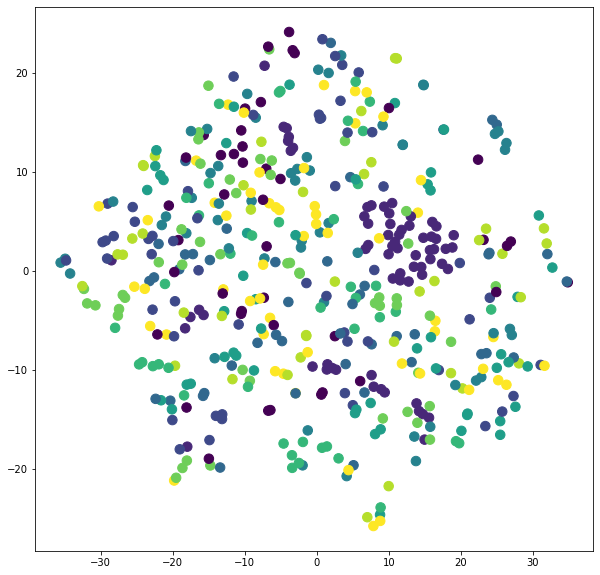

In [ ]:
X = latent_code.cpu().detach().numpy()

from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate=100, perplexity=20, n_iter=500).fit_transform(X)

np.random.seed(0)

x = X_embedded[:,0]
y = X_embedded[:,1]

colors = lb
area = 90 

plt.figure(figsize=(10, 10))

sc = plt.scatter(x, y, s=area, c=colors, alpha=1)

#Возможность отобразить метки на точках
#for i,label in enumerate(lb):
    #xp = x[i]
    #yp = y[i]
    #plt.text(xp+2, yp+3, label, fontsize=10)

plt.show()

Точки заполняют пространство пожалуй более равномерно чем у обычного Conditional AE, наблюдается меньше "пустых" пространств.